# **TRAINING**

### Initial configurations

In [1]:
!pip install scikit-learn scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Import necessary libraries
import os
import warnings
import logging
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import Model as tfkModel
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import register_keras_serializable
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from keras.callbacks import Callback
import IPython.display as display
from PIL import Image
import matplotlib.gridspec as gridspec
import json
import keras_cv
from tqdm import tqdm
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical

E0000 00:00:1732290942.610859      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D1122 15:55:42.618844727      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1122 15:55:42.618860637      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1122 15:55:42.618864050      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1122 15:55:42.618866560      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1122 15:55:42.618868962      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

In [3]:
tfk.mixed_precision.set_global_policy("mixed_bfloat16")

In [4]:
# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

### Set accelerator

In [5]:
def auto_select_accelerator():
    """
    Reference:
        * https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
        * https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training
    """
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")

    return strategy

In [6]:
# Setting che correct strategy for TPU / batch sizes
strategy = auto_select_accelerator()
numGPU = len(tf.config.list_physical_devices('GPU'))
numTPU = len(tf.config.list_logical_devices('TPU'))
print("Num GPUs Available: ", numGPU)
print("Num TPUs Available: ", numTPU)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1732290980.914152      13 service.cc:145] XLA service 0x5a8bf79a17c0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732290980.914207      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1732290980.914211      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1732290980.914214      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1732290980.914217      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1732290980.914220      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1732290980.914223      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1732290980.914226      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1732290980.914228      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [7]:
batch_size = 32
if numTPU != 0:
    batch_size = strategy.num_replicas_in_sync * 32

print(f"Batch size: {batch_size}")

Batch size: 256


### Reading data

In [8]:
train_path = "/kaggle/input/blood-cells-augmented/8_nocleanval_balanced_heavy_full_and_augMix_training_data.npz"
val_path = "/kaggle/input/blood-cells-augmented/8_noclean_balanced_heavy_full_and_augMix_validation_data.npz"
print(f"reading {train_path}")
print(f"reading {val_path}")

reading /kaggle/input/blood-cells-augmented/8_nocleanval_balanced_heavy_full_and_augMix_training_data.npz
reading /kaggle/input/blood-cells-augmented/8_noclean_balanced_heavy_full_and_augMix_validation_data.npz


In [9]:
data_train = np.load(train_path, allow_pickle=True)
X_train = data_train['images']
y_train = data_train['labels']

data_val = np.load(val_path, allow_pickle=True)
X_val = data_val['images']
y_val = data_val['labels']

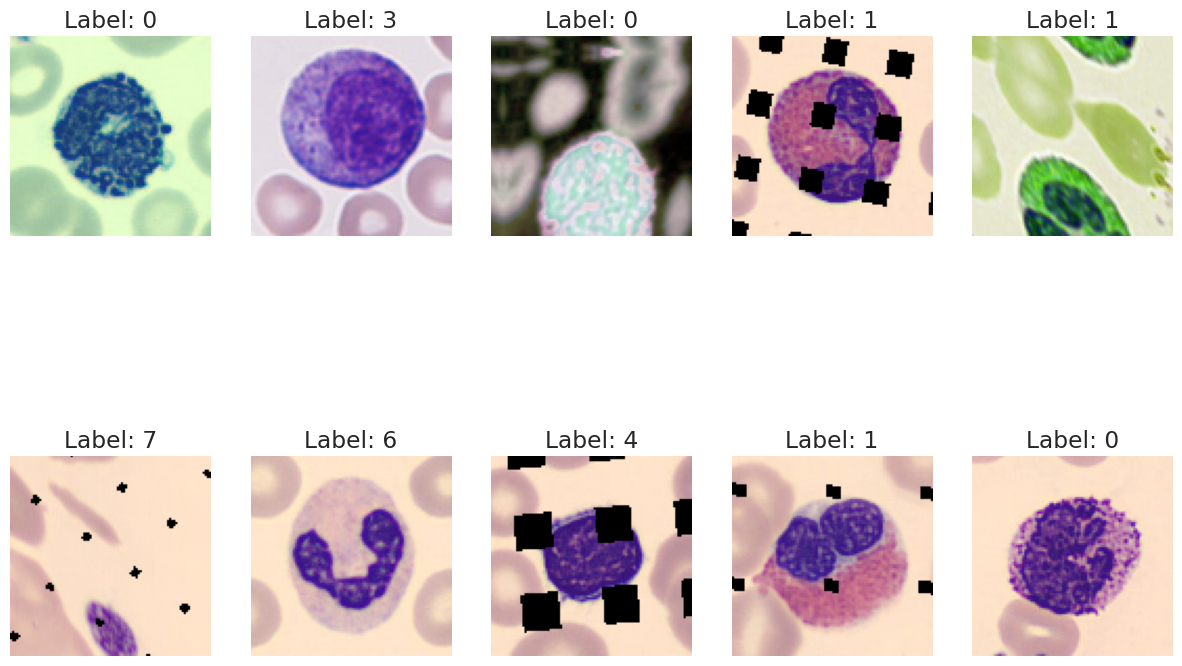

In [10]:
# Plot 10 random images from X_train
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    random_idx = np.random.randint(0, X_train.shape[0])
    plt.imshow(X_train[random_idx])
    plt.title(f"Label: {np.argmax(y_train[random_idx])}")
    plt.axis('off')
plt.show()

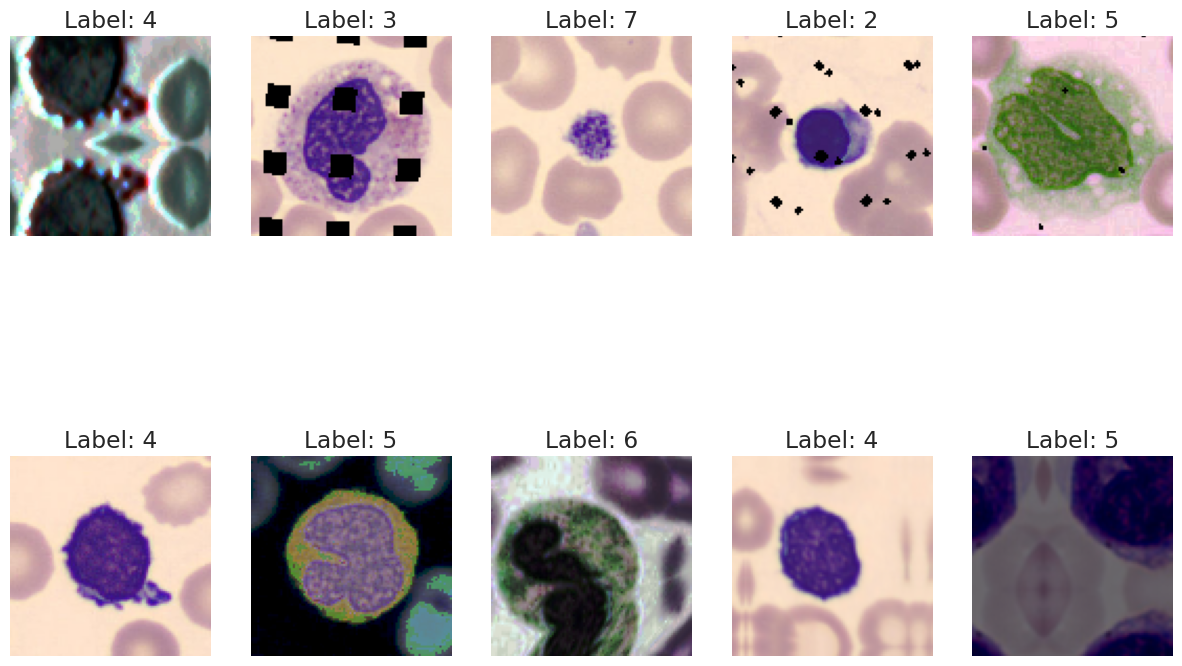

In [11]:
# Plot 10 random images from X_train
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    random_idx = np.random.randint(0, X_val.shape[0])
    plt.imshow(X_val[random_idx])
    plt.title(f"Label: {np.argmax(y_val[random_idx])}")
    plt.axis('off')
plt.show()

In [12]:
# Print the shapes of the loaded datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (91431, 96, 96, 3)
Training Label Shape: (91431, 8)
Validation Data Shape: (16137, 96, 96, 3)
Validation Label Shape: (16137, 8)


### Data transformation

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).cache().shuffle(65536).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).cache().shuffle(4096).batch(batch_size).prefetch(tf.data.AUTOTUNE)

### Custom callbacks

In [14]:
# Custom implementation of ReduceLROnPlateau
class CustomReduceLROnPlateau(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_accuracy', factor=0.33, patience=20, min_lr=1e-8, verbose=1):
        super(CustomReduceLROnPlateau, self).__init__()
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose
        self.wait = 0
        self.best = None
        self.new_lr = None

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        
        # Initialize best metric if it's the first epoch
        if self.best is None:
            self.best = current
            return

        # Check if the monitored metric has improved
        if current > self.best:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1

            # If patience is exceeded, reduce the learning rate
            if self.wait >= self.patience:
                old_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
                if old_lr == self.min_lr:
                    return
                self.new_lr = max(old_lr * self.factor, self.min_lr)
                self.model.optimizer.learning_rate.assign(self.new_lr)
                
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: reducing learning rate to {self.new_lr}.")
                
                self.wait = 0  # Reset patience counter

In [15]:
# Custom callback class for real-time plotting
class RealTimePlot(Callback):
    def on_train_begin(self, logs=None):
        # Initialize the lists that will store the metrics
        self.epochs = []
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

        # Set up the plot
        self.fig, (self.ax_loss, self.ax_acc) = plt.subplots(1, 2, figsize=(14, 5))
        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        # Append the metrics to the lists
        self.epochs.append(epoch)
        self.train_loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        self.train_acc.append(logs['categorical_accuracy'])
        self.val_acc.append(logs['val_categorical_accuracy'])

        # Clear the previous output
        display.clear_output(wait=True)

        # Plot training and validation loss
        self.ax_loss.clear()
        self.ax_loss.plot(self.epochs, self.train_loss, label='Training Loss')
        self.ax_loss.plot(self.epochs, self.val_loss, label='Validation Loss')
        self.ax_loss.set_title('Training and Validation Loss')
        self.ax_loss.set_xlabel('Epoch')
        self.ax_loss.set_ylabel('Loss')
        #self.ax_loss.set_ylim(top=2.5, bottom=0.0)
        self.ax_loss.legend()

        # Plot training and validation accuracy
        self.ax_acc.clear()
        self.ax_acc.plot(self.epochs, self.train_acc, label='Training Accuracy')
        self.ax_acc.plot(self.epochs, self.val_acc, label='Validation Accuracy')
        self.ax_acc.set_title('Training and Validation Accuracy')
        self.ax_acc.set_xlabel('Epoch')
        self.ax_acc.set_ylabel('Accuracy')
        self.ax_acc.legend()

        # Redraw the updated plots
        display.display(self.fig)
        plt.pause(0.1)

In [16]:
class DisplayLearningRateCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get the current learning rate from the optimizer and display it
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print(f"Epoch {epoch+1} : Learning rate = {tf.keras.backend.get_value(lr)}")

In [17]:
import csv
import os
from tensorflow.keras.callbacks import Callback

# Custom callback to log metrics
class CSVLoggerCallback(tf.keras.callbacks.Callback):
    def __init__(self, file_path, trial_id, hpparams):
        super().__init__()
        self.file_path = file_path
        self.trial_id = trial_id
        self.hpparams = hpparams
        print(self.hpparams)

        # Ensure directory exists
        os.makedirs(os.path.dirname(file_path), exist_ok=True)

        # Write header if the file does not exist
        if not os.path.exists(file_path):
            with open(file_path, mode='w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow([
                    'trial_id', 'n_dense_layers', 'initial_dense_neurons', 
                    'dropout_rate', 'l2_lambda', 'learning_rate', 'mult_next_layer', 'include_batch_normalization'
                    'epoch', 'loss', 'val_loss', 'categorical_accuracy', 'val_categorical_accuracy'
                ])

    def on_epoch_end(self, epoch, logs=None):
        # Append metrics to the file
        with open(self.file_path, mode='a', newline='') as f:
            writer = csv.writer(f)
            print(self.hpparams)
            writer.writerow([
                self.trial_id,
                self.hpparams['n_dense_layers'],
                self.hpparams['initial_dense_neurons'],
                self.hpparams['dropout_rate'],
                self.hpparams['l2_lambda'],
                self.hpparams['learning_rate'],
                self.hpparams['mult_next_layer'],
                self.hpparams['include_batch_normalization'],
                epoch,
                logs.get('loss'),
                logs.get('val_loss'),
                logs.get('categorical_accuracy'),
                logs.get('val_categorical_accuracy'),
            ])


### Model definition

In [18]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

steps_per_epoch = y_train.shape[0] // batch_size

print("Input Shape: ", input_shape)
print("Output Shape: ", output_shape)
print("Steps per epoch: ", steps_per_epoch)

Input Shape:  (96, 96, 3)
Output Shape:  8
Steps per epoch:  357


In [19]:
@register_keras_serializable()
class CustomCastLayer(tfk.layers.Layer):
    def call(self, inputs):
        return tf.cast(inputs * 255, tf.uint8)

@register_keras_serializable()
class CustomAugmentLayer(tfk.layers.Layer):
    def __init__(self, max_rotation=30.0, max_zoom=0.2, **kwargs):
        super(CustomAugmentLayer, self).__init__(**kwargs)
        self.max_rotation = max_rotation / 360.0
        self.max_zoom = max_zoom
        
    def call(self, inputs, training=False):
        if training:
            inputs = tf.image.random_flip_up_down(tf.image.random_flip_left_right(inputs))
        return inputs

In [20]:
def build_model(
            shape=input_shape, 
            n_labels=output_shape, 
            base_model_trainable=False, #standard definitions
            n_dense_layers=1, 
            initial_dense_neurons=1024, 
            min_neurons=64, # architecture definitions
            include_dropout=True, 
            dropout_rate=0.3, 
            l2_lambda=4e-3, # against overfitting
            learning_rate=1e-3,
            mult_next_layer = 1/2,
            include_batch_normalization = True):
    
    # The input layer
    inputs = tfkl.Input(shape=input_shape, name='Input')   
    
    # The two augmentation layers
    x = CustomCastLayer()(inputs)
    x = CustomAugmentLayer()(x, training=True)

    # The convnext layer with include top=False to take the convolutional part only
    base_model = tfk.applications.ConvNeXtXLarge(
                input_shape=input_shape,
                weights='imagenet',
                include_top=False
            )

    # Here we freeze the convnext to perform Tranfer Learning
    base_model.trainable = base_model_trainable

    x = base_model(x)
    x = tfkl.BatchNormalization(name="BatchNorm_After_ConvNeXt")(x) if include_batch_normalization else x # BatchNorm after ConvNeXt
    x = tfkl.GlobalAveragePooling2D()(x)

    # Hidden layers building
    neurons = initial_dense_neurons
    for k in range(n_dense_layers):
        x = tfkl.Dense(units=neurons, activation=None, name=f'Dense_layer_{k}', 
                       kernel_regularizer=tfk.regularizers.L2(l2_lambda))(x)
        x = tfkl.BatchNormalization(name=f'BatchNorm_Dense_layer_{k}')(x) if include_batch_normalization else x   # BatchNorm in dense layer
        x = tfkl.Activation('silu', name=f'Activation_layer_{k}')(x)  # Apply activation after BatchNorm
        if include_dropout:
            x = tfkl.Dropout(dropout_rate, name=f'Dropout_layer_{k}')(x)
        neurons = int(neurons * mult_next_layer)

    outputs = tfkl.Dense(output_shape, activation='softmax', name='output_layer')(x)

    # Final model building
    model = tfk.Model(inputs=inputs, outputs=outputs, name='TF-CNN')

    # Compile the model
    loss = tfk.losses.CategoricalFocalCrossentropy(
                                                alpha=0.25,
                                                gamma=2.0,
                                                from_logits=False,
                                                label_smoothing=0.0,
                                                axis=-1,
                                                reduction="sum_over_batch_size",
                                                name="categorical_focal_crossentropy",
                                                dtype=None,
                                            )
    # Metrics definition
    METRICS = [tfk.metrics.CategoricalAccuracy()]
    optimizer = tf.keras.optimizers.AdamW(
                                learning_rate=learning_rate,
                                weight_decay=l2_lambda,
                                beta_1=0.9,
                                beta_2=0.999,
                                epsilon=1e-07,
                                amsgrad=False,
                                use_ema=False,
                                ema_momentum=0.99,
                                name="adamw"
                            )
                                
    model.compile(loss=loss, optimizer=optimizer, metrics=METRICS)

    # Return the model
    return model


### Searching hyperparameters

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import gc

trial_counter = 0

def objective(params):
    n_dense_layers, initial_dense_neurons, dropout_rate, l2_lambda, learning_rate, mult_next_layer, include_batch_normalization = params

    global trial_counter
    trial_counter += 1  # Increment the counter for each trial
    trial_id = f"trial_{trial_counter}"  # Create a unique ID for this trial

    # Log trial parameters
    trial_params = {
        'n_dense_layers': n_dense_layers,
        'initial_dense_neurons': initial_dense_neurons,
        'dropout_rate': dropout_rate,
        'l2_lambda': l2_lambda,
        'learning_rate': learning_rate,
        'mult_next_layer': mult_next_layer,
        'include_batch_normalization': include_batch_normalization
    }
    print(f"Trying parameters: {trial_params}")

    with strategy.scope():
        model = build_model(
            base_model_trainable=False,
            n_dense_layers=n_dense_layers,
            initial_dense_neurons=initial_dense_neurons,
            min_neurons=dropout_rate,
            include_dropout=True,
            dropout_rate=0.3,
            l2_lambda=l2_lambda,
            learning_rate=learning_rate,
            mult_next_layer=mult_next_layer,
            include_batch_normalization = include_batch_normalization
        )

    patience = 20
    early_stopping = tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=patience, restore_best_weights=True)
    lr_reducer = CustomReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30, min_lr=1e-8)
    csv_logger = CSVLoggerCallback('./training_logs.csv', trial_id, trial_params)

    # Train the model
    model.fit(
        train_dataset,
        epochs=50,
        batch_size=batch_size,
        validation_data=val_dataset,
        shuffle=True,
        callbacks=[early_stopping, lr_reducer, DisplayLearningRateCallback(), csv_logger]
    )

    _, val_accuracy = model.evaluate(val_dataset, verbose=0)
    del model
    gc.collect()
    tf.keras.backend.clear_session()
    return -val_accuracy


In [22]:
search_space = [
    Integer(3, 8, name='n_dense_layers'),
    Integer(1024, 2048, name='initial_dense_neurons'),
    Real(0.3, 0.6, name='dropout_rate'),
    Real(0, 1e-6, name='l2_lambda'),
    Real(1e-6, 1e-3, name='learning_rate', prior="log-uniform"),
    Real(0.2, 0.5, name='mult_next_layer'),
    Categorical([True, False], name='include_batch_normalization')
]

In [23]:
# Perform Bayesian optimization
result = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=8,
    n_initial_points=3
)

Trying parameters: {'n_dense_layers': 8, 'initial_dense_neurons': 1071, 'dropout_rate': 0.3427143185477232, 'l2_lambda': 6.078195369068939e-07, 'learning_rate': 4.0220705604574155e-06, 'mult_next_layer': 0.2553891217756039, 'include_batch_normalization': False}


I0000 00:00:1732291075.442128      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1393257616/1393257616 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
{'n_dense_layers': 8, 'initial_dense_neurons': 1071, 'dropout_rate': 0.3427143185477232, 'l2_lambda': 6.078195369068939e-07, 'learning_rate': 4.0220705604574155e-06, 'mult_next_layer': 0.2553891217756039, 'include_batch_normalization': False}
Epoch 1/50


2024-11-22 15:59:09.604202: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1732291151.427303     832 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(ad9fa5e4c4d11e79:0:0), session_name()


  1/358 ━━━━━━━━━━━━━━━━━━━━ 3:52:18 39s/step - categorical_accuracy: 0.1875 - loss: 0.3992

I0000 00:00:1732291167.905807     832 tpu_compile_op_common.cc:245] Compilation of ad9fa5e4c4d11e79:0:0 with session name  took 16.478453912s and succeeded
I0000 00:00:1732291167.966101     832 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(ad9fa5e4c4d11e79:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_17908423056441982670", property.function_library_fingerprint = 9358443417703198689, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "32,96,96,3,;32,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732291167.966152     832 tpu_compilation_cache_interface.cc:541] After adding entry for key 

357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.1239 - loss: 0.3992

I0000 00:00:1732291186.126420     819 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(fea0264a0d78694d:0:0), session_name()


358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - categorical_accuracy: 0.1239 - loss: 0.3992

I0000 00:00:1732291205.939102     819 tpu_compile_op_common.cc:245] Compilation of fea0264a0d78694d:0:0 with session name  took 19.812633647s and succeeded
I0000 00:00:1732291205.998042     819 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(fea0264a0d78694d:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_17908423056441982670", property.function_library_fingerprint = 9358443417703198689, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "5,96,96,3,;5,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732291205.998076     819 tpu_compilation_cache_interface.cc:541] After adding entry for key fe

Epoch 1 : Learning rate = 4.0220706978288945e-06
{'n_dense_layers': 8, 'initial_dense_neurons': 1071, 'dropout_rate': 0.3427143185477232, 'l2_lambda': 6.078195369068939e-07, 'learning_rate': 4.0220705604574155e-06, 'mult_next_layer': 0.2553891217756039, 'include_batch_normalization': False}
358/358 ━━━━━━━━━━━━━━━━━━━━ 93s 150ms/step - categorical_accuracy: 0.1239 - loss: 0.3992 - val_categorical_accuracy: 0.1209 - val_loss: 0.3992
Epoch 2/50
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.1135 - loss: 0.3991Epoch 2 : Learning rate = 4.0220706978288945e-06
{'n_dense_layers': 8, 'initial_dense_neurons': 1071, 'dropout_rate': 0.3427143185477232, 'l2_lambda': 6.078195369068939e-07, 'learning_rate': 4.0220705604574155e-06, 'mult_next_layer': 0.2553891217756039, 'include_batch_normalization': False}
358/358 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - categorical_accuracy: 0.1135 - loss: 0.3991 - val_categorical_accuracy: 0.1209 - val_loss: 0.3991
Epoch 3/50
357/358 ━━━━━━━━━━━━

2024-11-22 16:29:58.784150: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1732293000.400757     785 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(ba5706632771c127:0:0), session_name()


  1/358 ━━━━━━━━━━━━━━━━━━━━ 3:16:45 33s/step - categorical_accuracy: 0.1250 - loss: 0.4002

I0000 00:00:1732293012.409386     785 tpu_compile_op_common.cc:245] Compilation of ba5706632771c127:0:0 with session name  took 12.008565712s and succeeded
I0000 00:00:1732293012.451941     785 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(ba5706632771c127:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_6551909069685938823", property.function_library_fingerprint = 1972582090445653565, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "32,96,96,3,;32,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732293012.451997     785 tpu_compilation_cache_interface.cc:541] After adding entry for key b

357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.1219 - loss: 0.4001

I0000 00:00:1732293031.490892     823 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(8d8c5a296900c5ec:0:0), session_name()


358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - categorical_accuracy: 0.1219 - loss: 0.4001

I0000 00:00:1732293043.879139     823 tpu_compile_op_common.cc:245] Compilation of 8d8c5a296900c5ec:0:0 with session name  took 12.388206781s and succeeded
I0000 00:00:1732293043.918844     823 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(8d8c5a296900c5ec:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_6551909069685938823", property.function_library_fingerprint = 1972582090445653565, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "5,96,96,3,;5,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732293043.918888     823 tpu_compilation_cache_interface.cc:541] After adding entry for key 8d8

Epoch 1 : Learning rate = 8.819055437925272e-06
{'n_dense_layers': 8, 'initial_dense_neurons': 2018, 'dropout_rate': 0.5689149961182001, 'l2_lambda': 7.253508642380475e-07, 'learning_rate': 8.819055387575292e-06, 'mult_next_layer': 0.21753152871778153, 'include_batch_normalization': False}
358/358 ━━━━━━━━━━━━━━━━━━━━ 80s 130ms/step - categorical_accuracy: 0.1219 - loss: 0.4001 - val_categorical_accuracy: 0.1293 - val_loss: 0.3999
Epoch 2/50
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.1272 - loss: 0.3999Epoch 2 : Learning rate = 8.819055437925272e-06
{'n_dense_layers': 8, 'initial_dense_neurons': 2018, 'dropout_rate': 0.5689149961182001, 'l2_lambda': 7.253508642380475e-07, 'learning_rate': 8.819055387575292e-06, 'mult_next_layer': 0.21753152871778153, 'include_batch_normalization': False}
358/358 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - categorical_accuracy: 0.1272 - loss: 0.3999 - val_categorical_accuracy: 0.1249 - val_loss: 0.3997
Epoch 3/50
358/358 ━━━━━━━━━━━━━━

2024-11-22 17:01:08.309462: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1732294870.089220     782 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(e59a7d66b11ef1df:0:0), session_name()


  1/358 ━━━━━━━━━━━━━━━━━━━━ 3:47:07 38s/step - categorical_accuracy: 0.0938 - loss: 0.4270

I0000 00:00:1732294886.456132     782 tpu_compile_op_common.cc:245] Compilation of e59a7d66b11ef1df:0:0 with session name  took 16.36681856s and succeeded
I0000 00:00:1732294886.528250     782 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(e59a7d66b11ef1df:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_6332038750730533462", property.function_library_fingerprint = 16231832363154744904, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "32,96,96,3,;32,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732294886.528306     782 tpu_compilation_cache_interface.cc:541] After adding entry for key e

357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - categorical_accuracy: 0.1674 - loss: 0.4535

I0000 00:00:1732294906.163351     767 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(f4d7f0b006729e9e:0:0), session_name()


358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - categorical_accuracy: 0.1675 - loss: 0.4535

I0000 00:00:1732294922.219863     767 tpu_compile_op_common.cc:245] Compilation of f4d7f0b006729e9e:0:0 with session name  took 16.056470101s and succeeded
I0000 00:00:1732294922.291746     767 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(f4d7f0b006729e9e:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_6332038750730533462", property.function_library_fingerprint = 16231832363154744904, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "5,96,96,3,;5,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732294922.291791     767 tpu_compilation_cache_interface.cc:541] After adding entry for key f4

Epoch 1 : Learning rate = 4.226248165650759e-06
{'n_dense_layers': 6, 'initial_dense_neurons': 2013, 'dropout_rate': 0.3667632699504481, 'l2_lambda': 7.166857598649658e-09, 'learning_rate': 4.22624812258859e-06, 'mult_next_layer': 0.4920187005332925, 'include_batch_normalization': True}
358/358 ━━━━━━━━━━━━━━━━━━━━ 100s 172ms/step - categorical_accuracy: 0.1676 - loss: 0.4534 - val_categorical_accuracy: 0.3890 - val_loss: 0.3206
Epoch 2/50
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - categorical_accuracy: 0.2755 - loss: 0.3723Epoch 2 : Learning rate = 4.226248165650759e-06
{'n_dense_layers': 6, 'initial_dense_neurons': 2013, 'dropout_rate': 0.3667632699504481, 'l2_lambda': 7.166857598649658e-09, 'learning_rate': 4.22624812258859e-06, 'mult_next_layer': 0.4920187005332925, 'include_batch_normalization': True}
358/358 ━━━━━━━━━━━━━━━━━━━━ 39s 79ms/step - categorical_accuracy: 0.2756 - loss: 0.3722 - val_categorical_accuracy: 0.4708 - val_loss: 0.2765
Epoch 3/50
357/358 ━━━━━━━━━━━━━━━━━━━

2024-11-22 17:34:37.721995: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1732296879.342922     838 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(9e42888607942437:0:0), session_name()


  1/358 ━━━━━━━━━━━━━━━━━━━━ 3:34:44 36s/step - categorical_accuracy: 0.0312 - loss: 0.5364

I0000 00:00:1732296894.085946     838 tpu_compile_op_common.cc:245] Compilation of 9e42888607942437:0:0 with session name  took 14.742967403s and succeeded
I0000 00:00:1732296894.138936     838 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(9e42888607942437:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_4973812552489322309", property.function_library_fingerprint = 8573505836629915452, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "32,96,96,3,;32,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732296894.138988     838 tpu_compilation_cache_interface.cc:541] After adding entry for key 9

357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.2689 - loss: 0.3897

I0000 00:00:1732296913.622127     829 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(4ab313667f063301:0:0), session_name()


358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - categorical_accuracy: 0.2692 - loss: 0.3895

I0000 00:00:1732296928.794944     829 tpu_compile_op_common.cc:245] Compilation of 4ab313667f063301:0:0 with session name  took 15.172769593s and succeeded
I0000 00:00:1732296928.847163     829 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(4ab313667f063301:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_4973812552489322309", property.function_library_fingerprint = 8573505836629915452, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "5,96,96,3,;5,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732296928.847219     829 tpu_compilation_cache_interface.cc:541] After adding entry for key 4ab

Epoch 1 : Learning rate = 1.5960891687427647e-05
{'n_dense_layers': 5, 'initial_dense_neurons': 1943, 'dropout_rate': 0.3524421094543674, 'l2_lambda': 1.8565546442599703e-07, 'learning_rate': 1.5960891508122008e-05, 'mult_next_layer': 0.44626196636451776, 'include_batch_normalization': True}
358/358 ━━━━━━━━━━━━━━━━━━━━ 98s 173ms/step - categorical_accuracy: 0.2695 - loss: 0.3893 - val_categorical_accuracy: 0.5932 - val_loss: 0.2008
Epoch 2/50
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.5312 - loss: 0.2187Epoch 2 : Learning rate = 1.5960891687427647e-05
{'n_dense_layers': 5, 'initial_dense_neurons': 1943, 'dropout_rate': 0.3524421094543674, 'l2_lambda': 1.8565546442599703e-07, 'learning_rate': 1.5960891508122008e-05, 'mult_next_layer': 0.44626196636451776, 'include_batch_normalization': True}
358/358 ━━━━━━━━━━━━━━━━━━━━ 38s 78ms/step - categorical_accuracy: 0.5314 - loss: 0.2186 - val_categorical_accuracy: 0.6754 - val_loss: 0.1498
Epoch 3/50
357/358 ━━━━━━━━━━

2024-11-22 18:07:41.787907: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1732298863.475097     781 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(988da2c81dcd3db6:0:0), session_name()


  1/358 ━━━━━━━━━━━━━━━━━━━━ 3:28:43 35s/step - categorical_accuracy: 0.1562 - loss: 0.4728

I0000 00:00:1732298876.993220     781 tpu_compile_op_common.cc:245] Compilation of 988da2c81dcd3db6:0:0 with session name  took 13.518055511s and succeeded
I0000 00:00:1732298877.046577     781 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(988da2c81dcd3db6:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_11205122523343376226", property.function_library_fingerprint = 11387107837284397750, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "32,96,96,3,;32,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732298877.046625     781 tpu_compilation_cache_interface.cc:541] After adding entry for key

357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.1487 - loss: 0.4818

I0000 00:00:1732298896.091007     822 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(e0923da5f8f7662f:0:0), session_name()


358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - categorical_accuracy: 0.1488 - loss: 0.4818

I0000 00:00:1732298909.390861     822 tpu_compile_op_common.cc:245] Compilation of e0923da5f8f7662f:0:0 with session name  took 13.299813253s and succeeded
I0000 00:00:1732298909.430976     822 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(e0923da5f8f7662f:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_11205122523343376226", property.function_library_fingerprint = 11387107837284397750, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "5,96,96,3,;5,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732298909.431025     822 tpu_compilation_cache_interface.cc:541] After adding entry for key e

Epoch 1 : Learning rate = 9.999999974752427e-07
{'n_dense_layers': 3, 'initial_dense_neurons': 1024, 'dropout_rate': 0.6, 'l2_lambda': 1e-06, 'learning_rate': 1e-06, 'mult_next_layer': 0.2, 'include_batch_normalization': True}
358/358 ━━━━━━━━━━━━━━━━━━━━ 94s 165ms/step - categorical_accuracy: 0.1488 - loss: 0.4817 - val_categorical_accuracy: 0.2438 - val_loss: 0.3677
Epoch 2/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.2267 - loss: 0.4118Epoch 2 : Learning rate = 9.999999974752427e-07
{'n_dense_layers': 3, 'initial_dense_neurons': 1024, 'dropout_rate': 0.6, 'l2_lambda': 1e-06, 'learning_rate': 1e-06, 'mult_next_layer': 0.2, 'include_batch_normalization': True}
358/358 ━━━━━━━━━━━━━━━━━━━━ 38s 79ms/step - categorical_accuracy: 0.2268 - loss: 0.4118 - val_categorical_accuracy: 0.3251 - val_loss: 0.3331
Epoch 3/50
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - categorical_accuracy: 0.2804 - loss: 0.3714Epoch 3 : Learning rate = 9.999999974752427e-07
{'n_dense_layer

2024-11-22 18:41:25.215813: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1732300887.102437     822 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(aabe6e750ce0a9fb:0:0), session_name()


  1/358 ━━━━━━━━━━━━━━━━━━━━ 3:48:20 38s/step - categorical_accuracy: 0.1562 - loss: 0.3998

I0000 00:00:1732300902.095363     822 tpu_compile_op_common.cc:245] Compilation of aabe6e750ce0a9fb:0:0 with session name  took 14.992856221s and succeeded
I0000 00:00:1732300902.144980     822 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(aabe6e750ce0a9fb:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_9274162820683799870", property.function_library_fingerprint = 3878113172239684577, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "32,96,96,3,;32,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732300902.145028     822 tpu_compilation_cache_interface.cc:541] After adding entry for key a

357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - categorical_accuracy: 0.1274 - loss: 0.3986

I0000 00:00:1732300923.305271     815 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(bf3bf3dd07b66671:0:0), session_name()


358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - categorical_accuracy: 0.1273 - loss: 0.3986

I0000 00:00:1732300938.634392     815 tpu_compile_op_common.cc:245] Compilation of bf3bf3dd07b66671:0:0 with session name  took 15.32907981s and succeeded
I0000 00:00:1732300938.682752     815 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(bf3bf3dd07b66671:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_9274162820683799870", property.function_library_fingerprint = 3878113172239684577, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "5,96,96,3,;5,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732300938.682808     815 tpu_compilation_cache_interface.cc:541] After adding entry for key bf3b

Epoch 1 : Learning rate = 0.0010000000474974513
{'n_dense_layers': 8, 'initial_dense_neurons': 1024, 'dropout_rate': 0.3, 'l2_lambda': 1e-06, 'learning_rate': 0.001, 'mult_next_layer': 0.2, 'include_batch_normalization': True}
358/358 ━━━━━━━━━━━━━━━━━━━━ 90s 144ms/step - categorical_accuracy: 0.1273 - loss: 0.3986 - val_categorical_accuracy: 0.1234 - val_loss: 0.3980
Epoch 2/50
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - categorical_accuracy: 0.1248 - loss: 0.3980Epoch 2 : Learning rate = 0.0010000000474974513
{'n_dense_layers': 8, 'initial_dense_neurons': 1024, 'dropout_rate': 0.3, 'l2_lambda': 1e-06, 'learning_rate': 0.001, 'mult_next_layer': 0.2, 'include_batch_normalization': True}
358/358 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - categorical_accuracy: 0.1248 - loss: 0.3980 - val_categorical_accuracy: 0.1239 - val_loss: 0.3980
Epoch 3/50
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - categorical_accuracy: 0.1289 - loss: 0.3980Epoch 3 : Learning rate = 0.0010000000474974513
{'n_dense_layer

2024-11-22 19:04:23.697532: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1732302265.476575     818 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(61fc8552a1551e3:0:0), session_name()


  1/358 ━━━━━━━━━━━━━━━━━━━━ 3:43:46 38s/step - categorical_accuracy: 0.2188 - loss: 0.4711

I0000 00:00:1732302281.059303     818 tpu_compile_op_common.cc:245] Compilation of 61fc8552a1551e3:0:0 with session name  took 15.582662669s and succeeded
I0000 00:00:1732302281.133093     818 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(61fc8552a1551e3:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_14208130333171628036", property.function_library_fingerprint = 16152069085340197230, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "32,96,96,3,;32,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732302281.133156     818 tpu_compilation_cache_interface.cc:541] After adding entry for key 6

357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_accuracy: 0.3916 - loss: 0.3186

I0000 00:00:1732302301.121286     818 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(7a5d53c2d619d13a:0:0), session_name()


358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - categorical_accuracy: 0.3919 - loss: 0.3184

I0000 00:00:1732302315.746046     818 tpu_compile_op_common.cc:245] Compilation of 7a5d53c2d619d13a:0:0 with session name  took 14.624720838s and succeeded
I0000 00:00:1732302315.804925     818 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(7a5d53c2d619d13a:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_14208130333171628036", property.function_library_fingerprint = 16152069085340197230, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "5,96,96,3,;5,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732302315.804974     818 tpu_compilation_cache_interface.cc:541] After adding entry for key 7

Epoch 1 : Learning rate = 3.006851147802081e-05
{'n_dense_layers': 4, 'initial_dense_neurons': 1513, 'dropout_rate': 0.30555542890929227, 'l2_lambda': 5.049131377867752e-07, 'learning_rate': 3.0068510995830465e-05, 'mult_next_layer': 0.3806903518129778, 'include_batch_normalization': True}
358/358 ━━━━━━━━━━━━━━━━━━━━ 99s 173ms/step - categorical_accuracy: 0.3922 - loss: 0.3182 - val_categorical_accuracy: 0.6938 - val_loss: 0.1480
Epoch 2/50
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - categorical_accuracy: 0.6772 - loss: 0.1517Epoch 2 : Learning rate = 3.006851147802081e-05
{'n_dense_layers': 4, 'initial_dense_neurons': 1513, 'dropout_rate': 0.30555542890929227, 'l2_lambda': 5.049131377867752e-07, 'learning_rate': 3.0068510995830465e-05, 'mult_next_layer': 0.3806903518129778, 'include_batch_normalization': True}
358/358 ━━━━━━━━━━━━━━━━━━━━ 39s 79ms/step - categorical_accuracy: 0.6773 - loss: 0.1517 - val_categorical_accuracy: 0.7488 - val_loss: 0.1111
Epoch 3/50
357/358 ━━━━━━━━━━━━━━

2024-11-22 19:38:04.277426: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1732304285.838061     775 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(a2c106f262d8d06f:0:0), session_name()


  1/358 ━━━━━━━━━━━━━━━━━━━━ 3:25:34 35s/step - categorical_accuracy: 0.1250 - loss: 0.4597

I0000 00:00:1732304299.333919     775 tpu_compile_op_common.cc:245] Compilation of a2c106f262d8d06f:0:0 with session name  took 13.495797098s and succeeded
I0000 00:00:1732304299.394423     775 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(a2c106f262d8d06f:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_13070829525717251775", property.function_library_fingerprint = 7494947891183555531, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "32,96,96,3,;32,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732304299.394493     775 tpu_compilation_cache_interface.cc:541] After adding entry for key 

357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.1345 - loss: 0.4125

I0000 00:00:1732304318.103774     800 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(10569e75543dfcab:0:0), session_name()


358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - categorical_accuracy: 0.1345 - loss: 0.4125

I0000 00:00:1732304331.896154     800 tpu_compile_op_common.cc:245] Compilation of 10569e75543dfcab:0:0 with session name  took 13.792333071s and succeeded
I0000 00:00:1732304331.947020     800 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(10569e75543dfcab:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_13070829525717251775", property.function_library_fingerprint = 7494947891183555531, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "5,96,96,3,;5,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1732304331.947064     800 tpu_compilation_cache_interface.cc:541] After adding entry for key 10

Epoch 1 : Learning rate = 9.999999974752427e-07
{'n_dense_layers': 4, 'initial_dense_neurons': 1024, 'dropout_rate': 0.6, 'l2_lambda': 1e-06, 'learning_rate': 1e-06, 'mult_next_layer': 0.2, 'include_batch_normalization': False}
358/358 ━━━━━━━━━━━━━━━━━━━━ 94s 167ms/step - categorical_accuracy: 0.1345 - loss: 0.4125 - val_categorical_accuracy: 0.1918 - val_loss: 0.3905
Epoch 2/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.1677 - loss: 0.3946Epoch 2 : Learning rate = 9.999999974752427e-07
{'n_dense_layers': 4, 'initial_dense_neurons': 1024, 'dropout_rate': 0.6, 'l2_lambda': 1e-06, 'learning_rate': 1e-06, 'mult_next_layer': 0.2, 'include_batch_normalization': False}
358/358 ━━━━━━━━━━━━━━━━━━━━ 37s 76ms/step - categorical_accuracy: 0.1677 - loss: 0.3946 - val_categorical_accuracy: 0.2359 - val_loss: 0.3795
Epoch 3/50
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.2011 - loss: 0.3814Epoch 3 : Learning rate = 9.999999974752427e-07
{'n_dense_lay

### See results

In [24]:
# Best hyperparameters
best_hyperparams = {
    'n_dense_layers': result.x[0],
    'initial_dense_neurons': result.x[1],
    'dropout_rate': result.x[2],
    'l2_lambda': result.x[3],
    'learning_rate': result.x[4],
    'mult_next_layer': result.x[5],
    'include_batch_normalization': result.x[6]
}
print("Best Hyperparameters:", best_hyperparams)

Best Hyperparameters: {'n_dense_layers': 4, 'initial_dense_neurons': 1513, 'dropout_rate': 0.30555542890929227, 'l2_lambda': 5.049131377867752e-07, 'learning_rate': 3.0068510995830465e-05, 'mult_next_layer': 0.3806903518129778, 'include_batch_normalization': True}


In [25]:
result.x

[4,
 1513,
 0.30555542890929227,
 5.049131377867752e-07,
 3.0068510995830465e-05,
 0.3806903518129778,
 True]

In [26]:
result.fun

-0.8498513102531433

### Plots

In [27]:
def plot_results(csv_file):
    # Read the CSV file
    data = pd.read_csv(csv_file)

    # Iterate over trials and plot
    trials = data['trial_id'].unique()
    for trial in trials:
        # Extract trial-specific data
        trial_data = data[data['trial_id'] == trial]
        
        # Extract parameters
        params = trial_data.iloc[0][['n_dense_layers', 'initial_dense_neurons', 'dropout_rate', 
                                     'l2_lambda', 'learning_rate', 'mult_next_layer', 'include_batch_normalization']].to_dict()
        params_str = ", ".join([f"{key}={value}" for key, value in params.items()])

        # Create the plot
        plt.figure(figsize=(14, 6))

        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(trial_data['epoch'], trial_data['loss'], label='Training Loss', marker='o')
        plt.plot(trial_data['epoch'], trial_data['val_loss'], label='Validation Loss', marker='x')
        plt.title(f"Loss for {trial}\n({params_str})")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(trial_data['epoch'], trial_data['categorical_accuracy'], label='Training Accuracy', marker='o')
        plt.plot(trial_data['epoch'], trial_data['val_categorical_accuracy'], label='Validation Accuracy', marker='x')
        plt.title(f"Accuracy for {trial}\n")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.show()


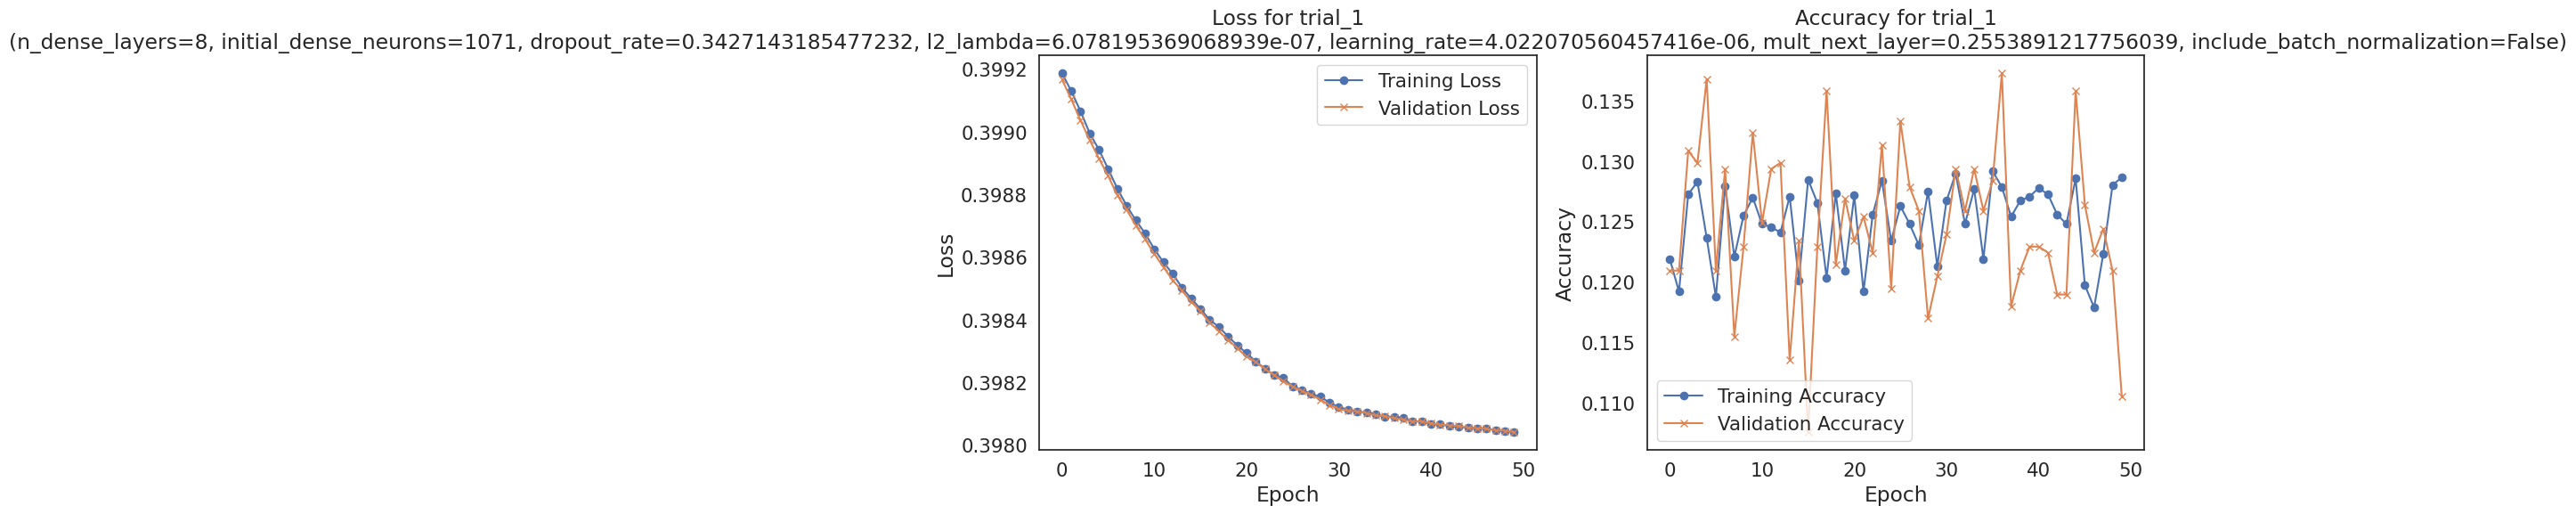

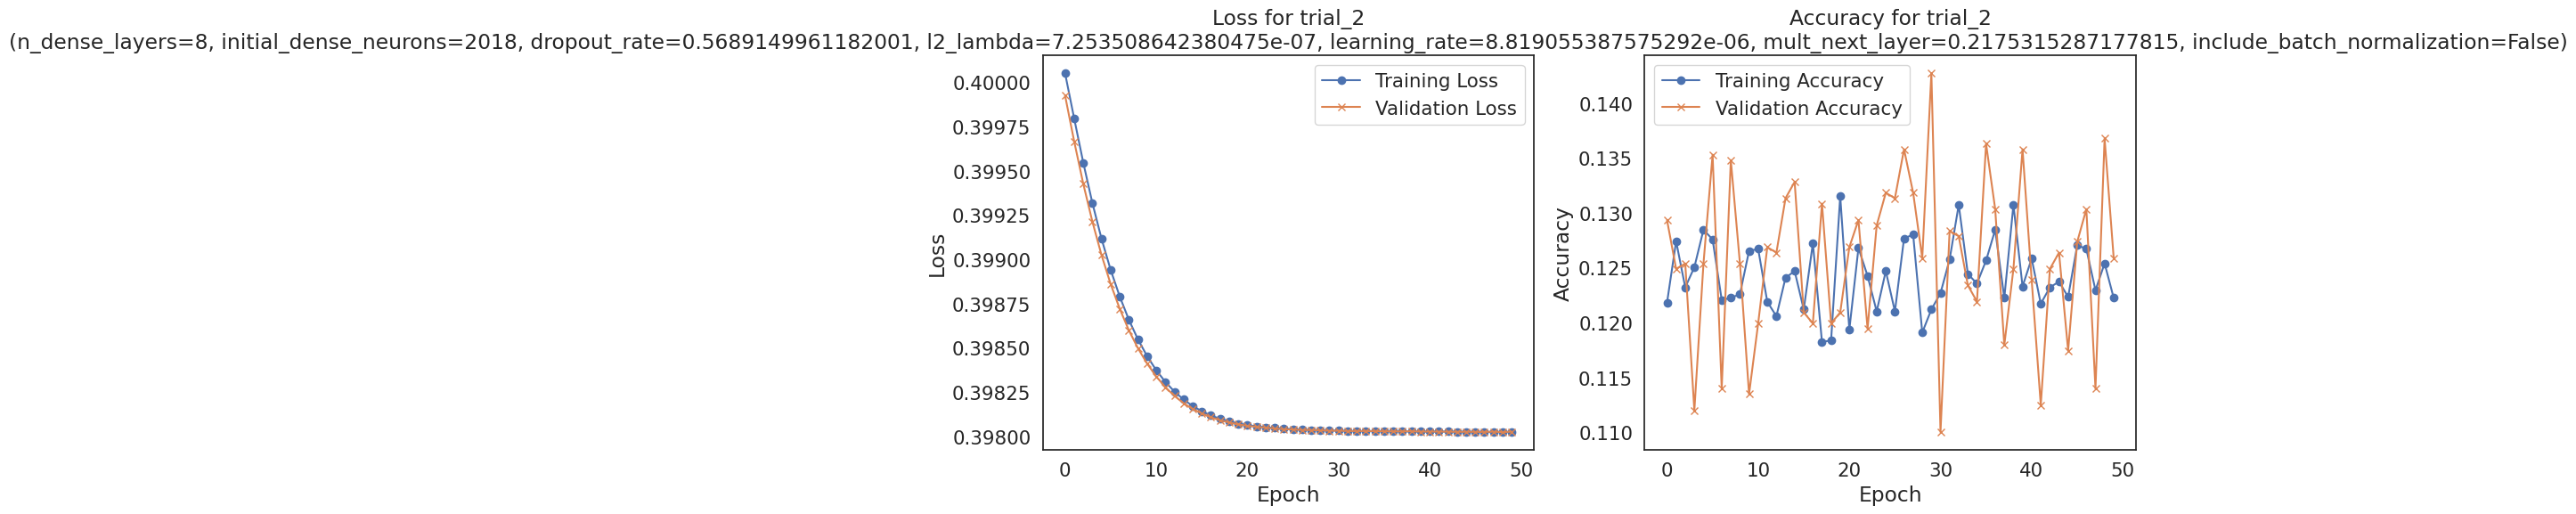

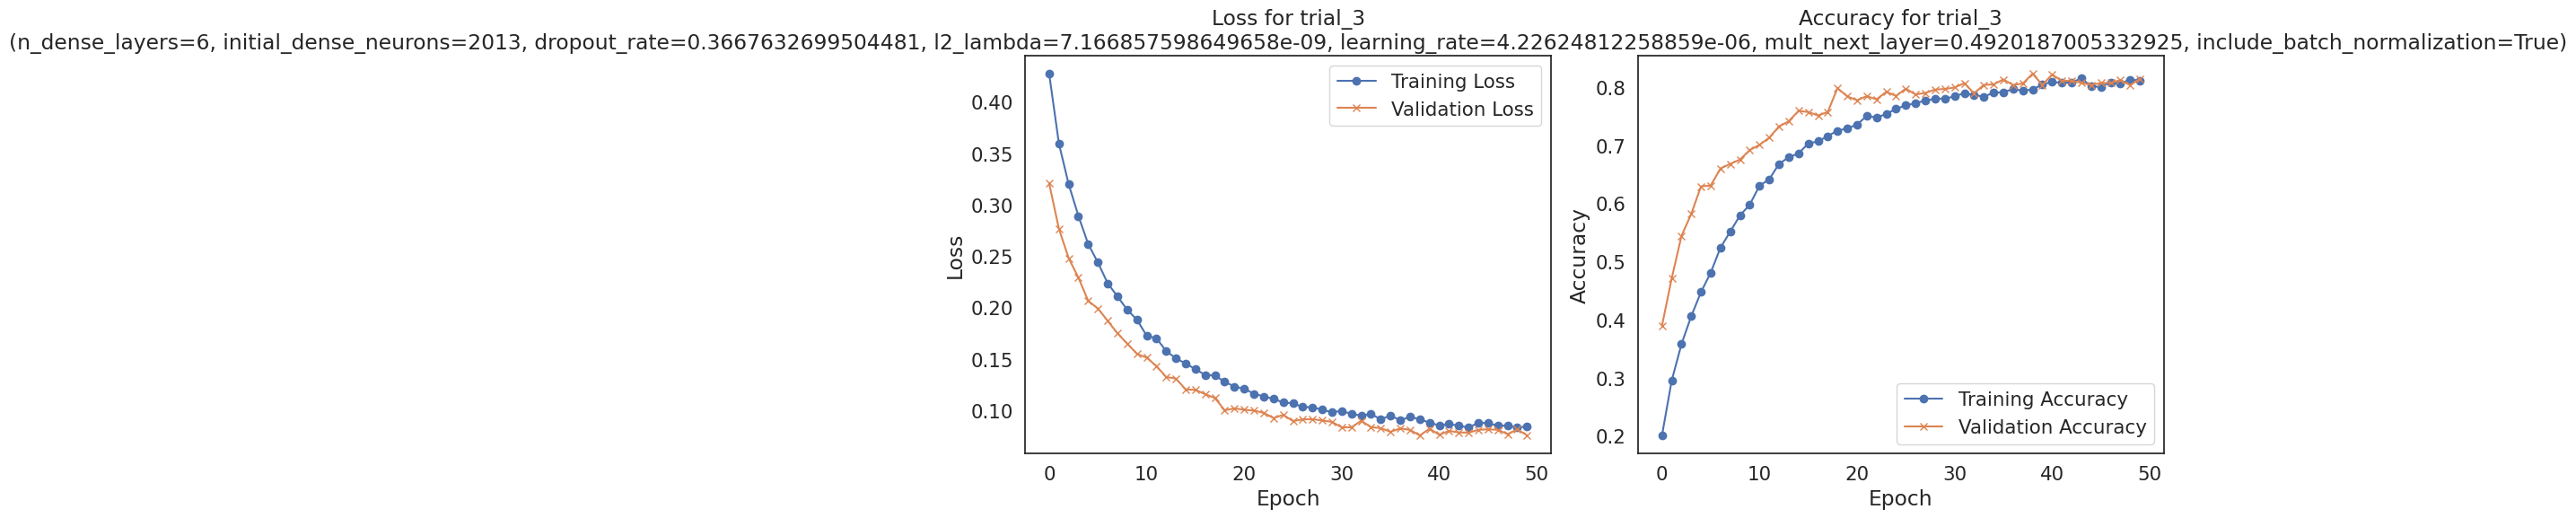

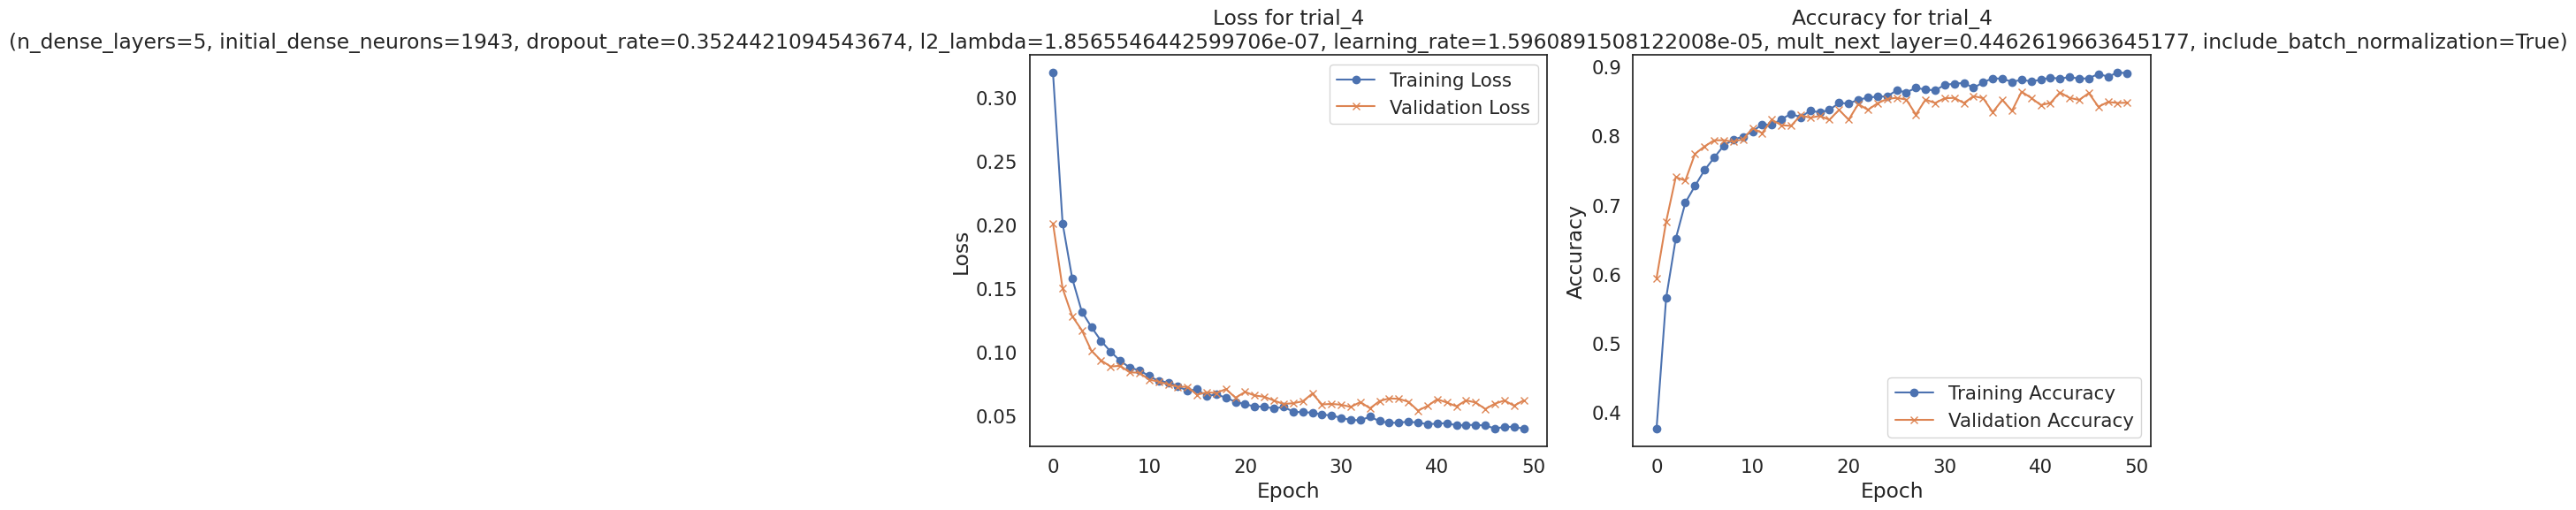

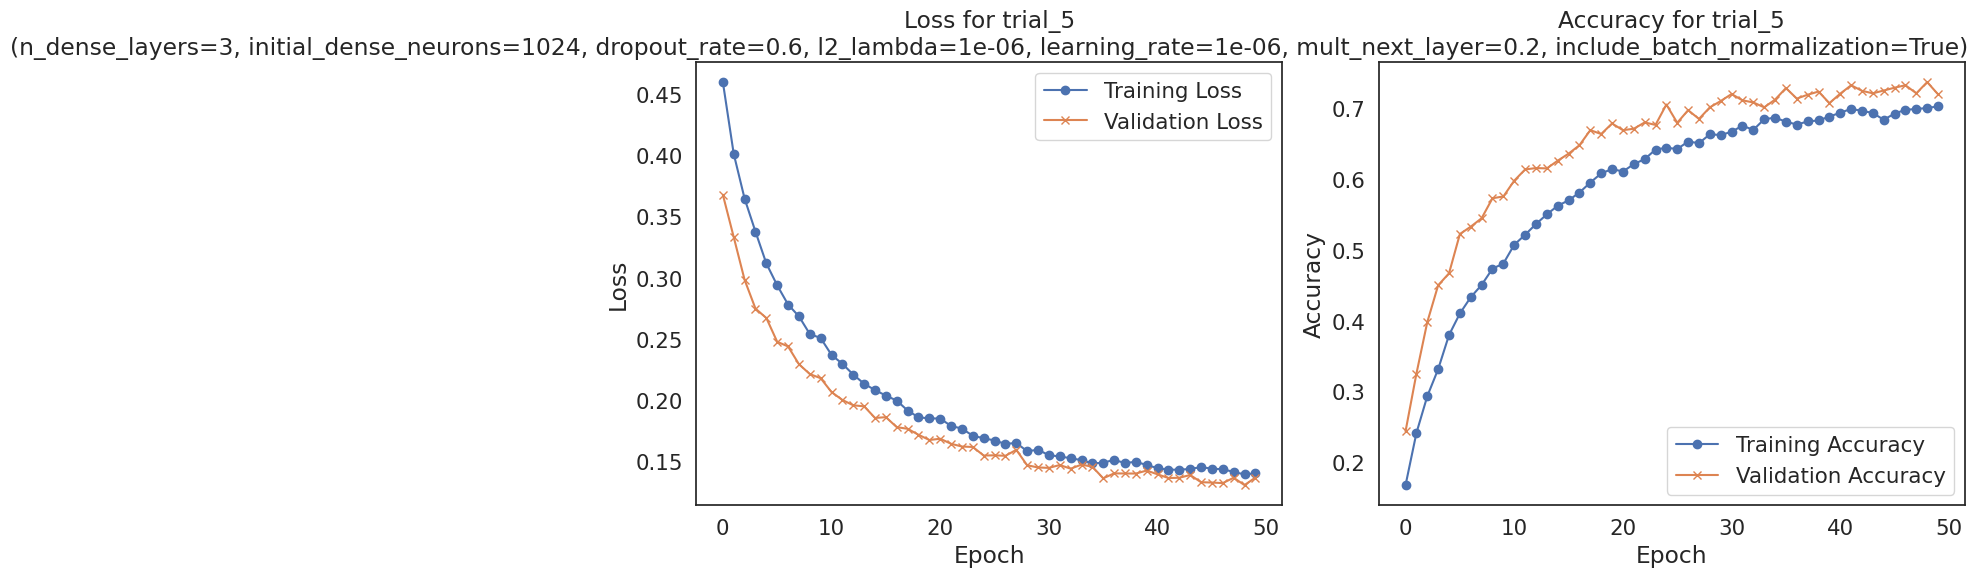

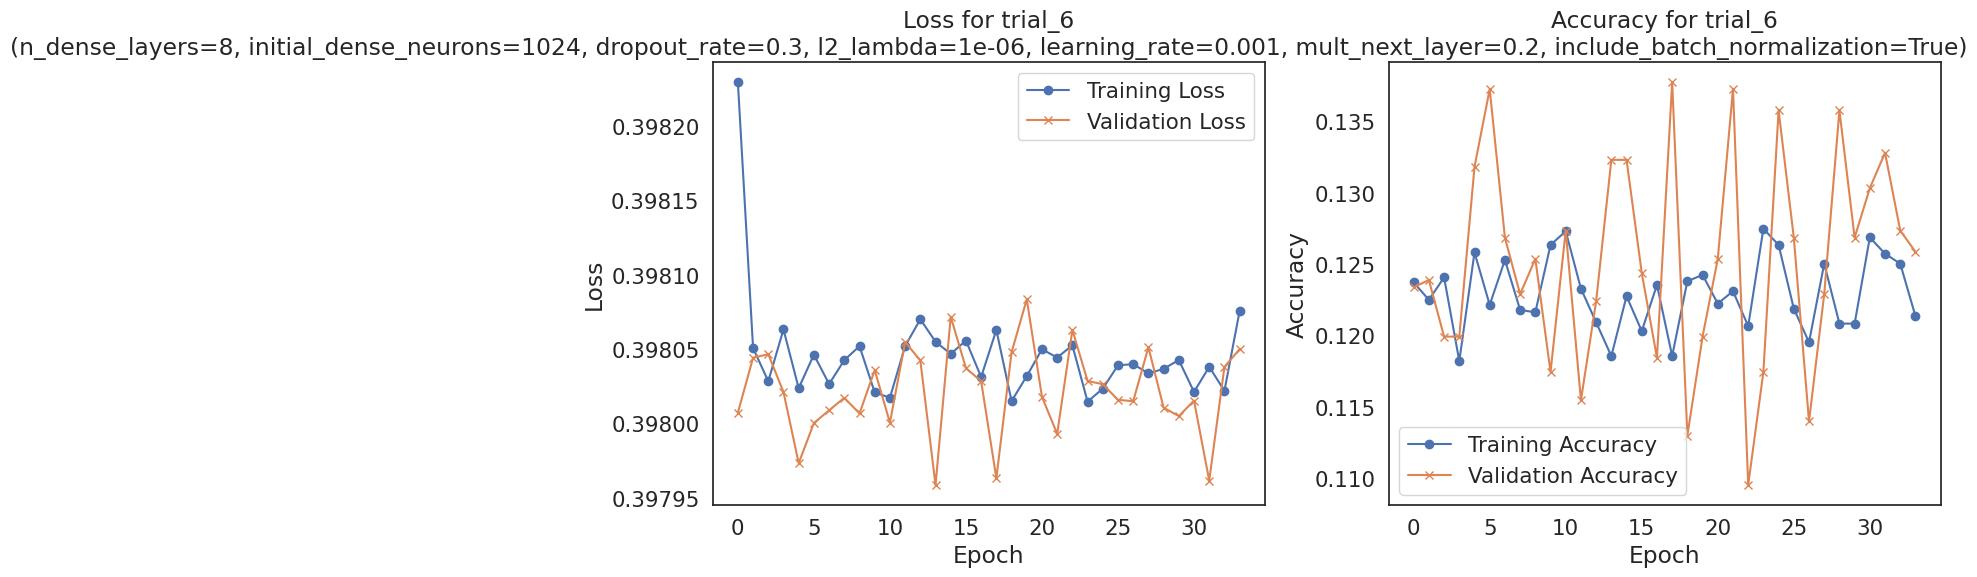

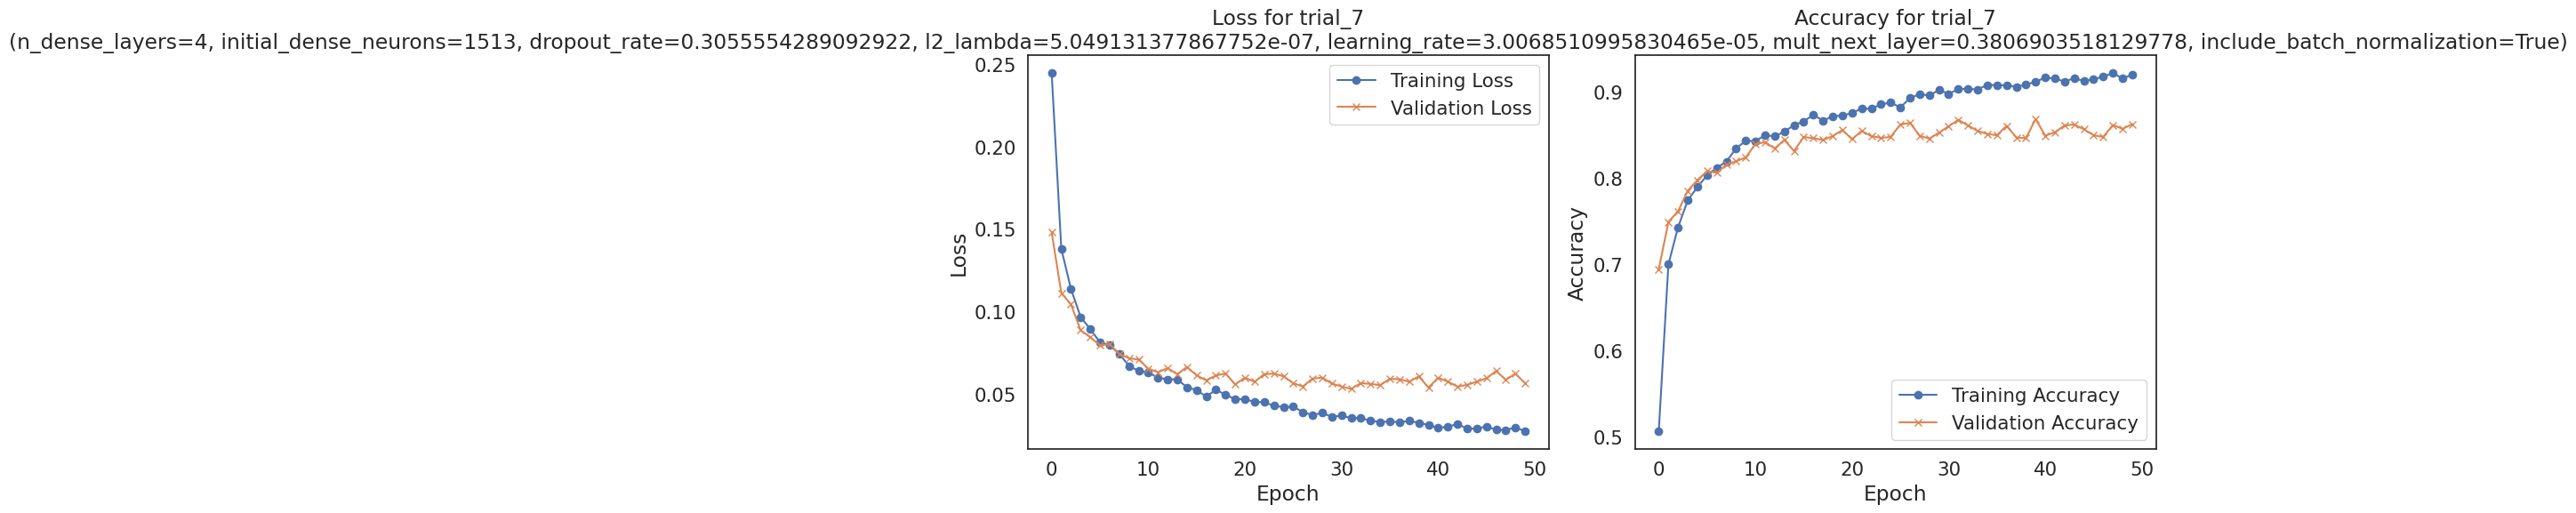

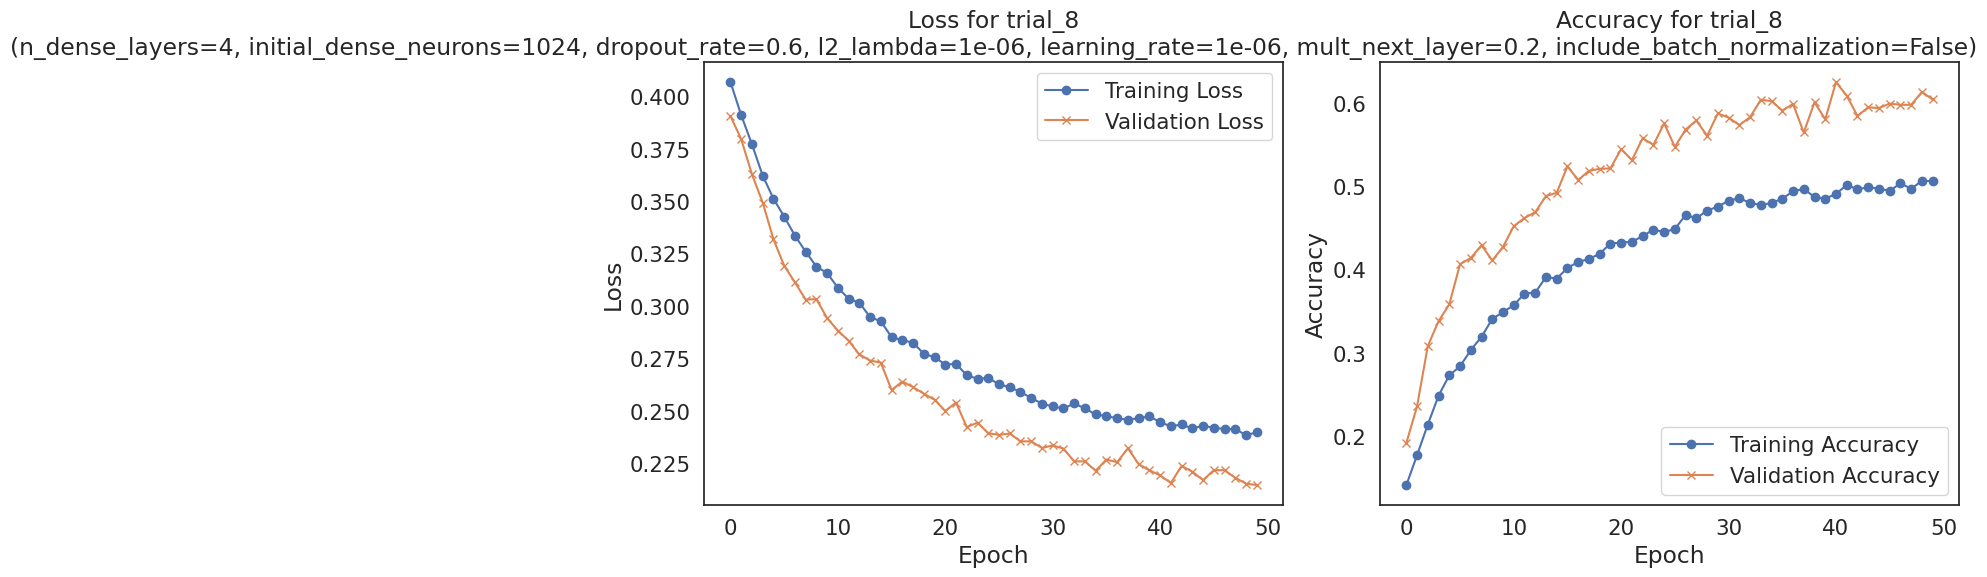

In [31]:
plot_results("/kaggle/input/trainning-log-1-part2/training_logs.csv")